Question 1

<ipython-input-1-881627a00e6b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ConvertedCompYearly'] = pd.to_numeric(df_clean['ConvertedCompYearly'], errors='coerce')


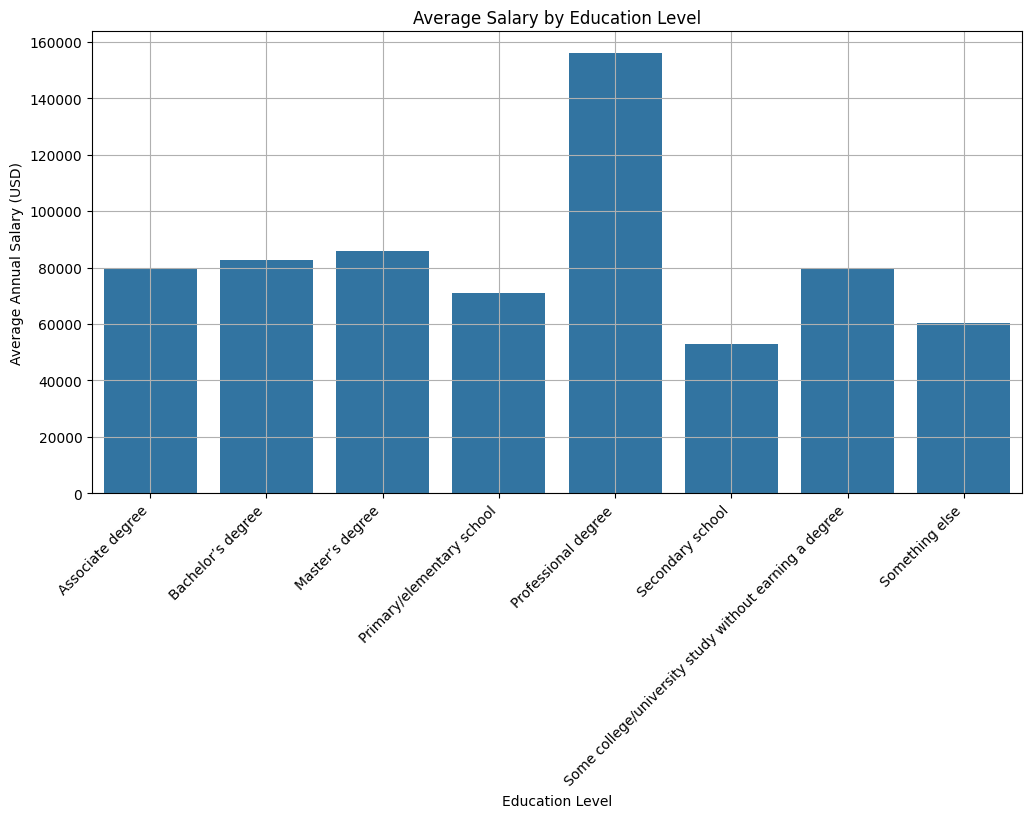

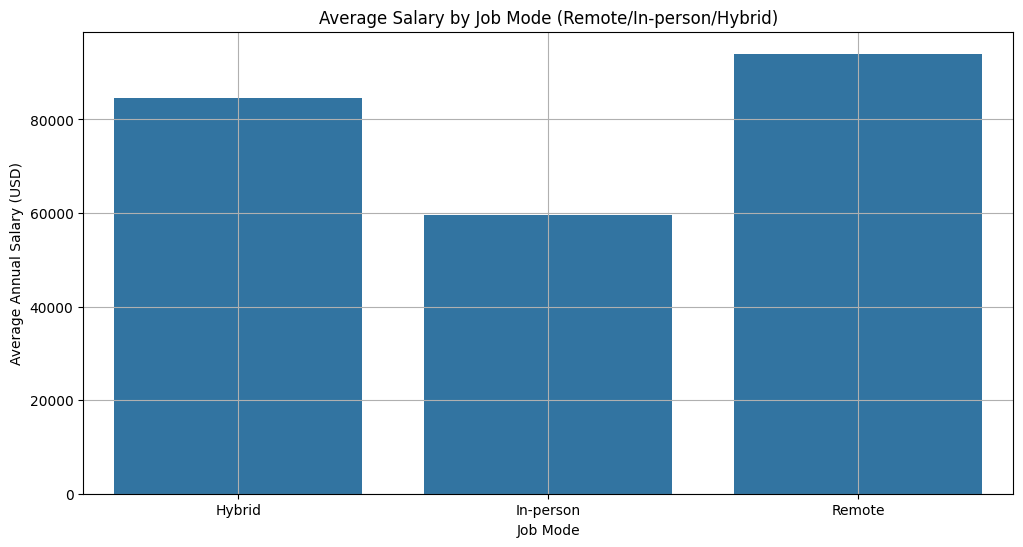

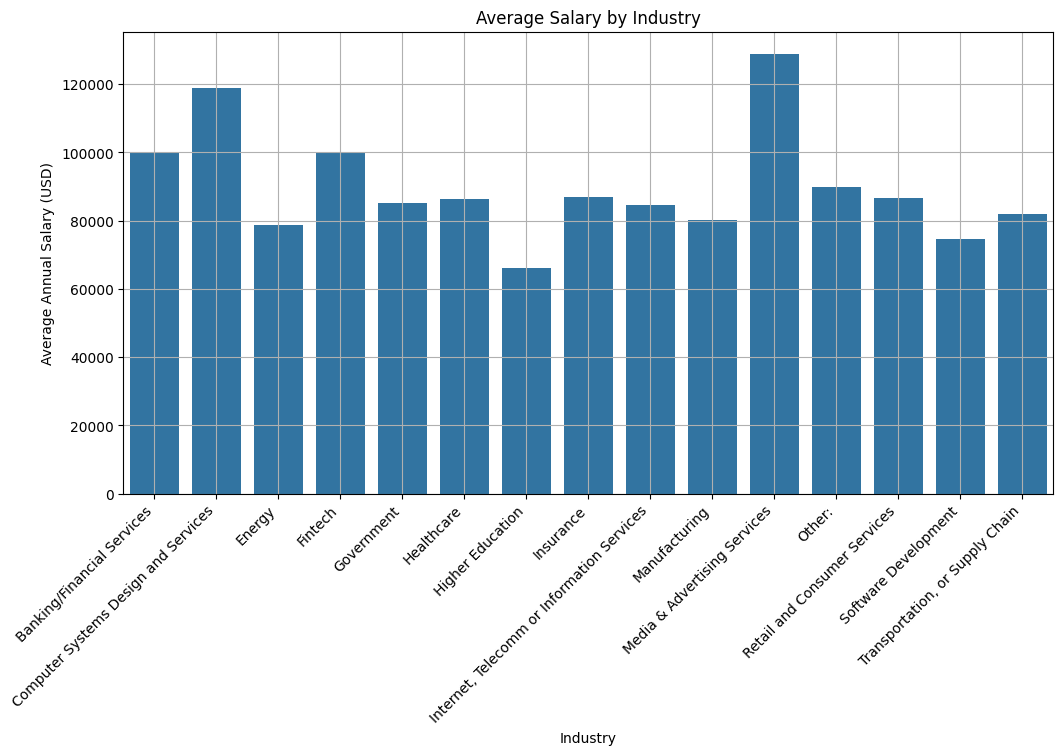

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'clean_kaggle_data_2024.csv'
df = pd.read_csv(file_path)

# Clean the dataset by removing rows with missing data in relevant columns
df_clean = df.dropna(subset=['EdLevel', 'ConvertedCompYearly', 'RemoteWork', 'Industry'])

# Convert salary to numeric, if needed
df_clean['ConvertedCompYearly'] = pd.to_numeric(df_clean['ConvertedCompYearly'], errors='coerce')

# 1. Education Level vs Average Annual Salary
plt.figure(figsize=(12, 6))
df_edu_salary = df_clean.groupby('EdLevel')['ConvertedCompYearly'].mean().reset_index()
sns.barplot(data=df_edu_salary, x='EdLevel', y='ConvertedCompYearly')
plt.title('Average Salary by Education Level')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Education Level')
plt.ylabel('Average Annual Salary (USD)')
plt.grid(True)
plt.show()

# 2. Remote Work vs ConvertedCompYearly (Salary)
plt.figure(figsize=(12, 6))
df_remote_salary = df_clean.groupby('RemoteWork')['ConvertedCompYearly'].mean().reset_index()
sns.barplot(data=df_remote_salary, x='RemoteWork', y='ConvertedCompYearly')
plt.title('Average Salary by Job Mode (Remote/In-person/Hybrid)')
plt.xlabel('Job Mode')
plt.ylabel('Average Annual Salary (USD)')
plt.grid(True)
plt.show()

# 3. Industry vs ConvertedCompYearly (Salary)
plt.figure(figsize=(12, 6))
df_industry_salary = df_clean.groupby('Industry')['ConvertedCompYearly'].mean().reset_index()
sns.barplot(data=df_industry_salary, x='Industry', y='ConvertedCompYearly')
plt.title('Average Salary by Industry')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Industry')
plt.ylabel('Average Annual Salary (USD)')
plt.grid(True)
plt.show()



Question 2a

In [21]:
import pandas as pd

# Load the dataset
file_path = 'clean_kaggle_data_2024.csv'
df = pd.read_csv(file_path)

# Filter the dataset to include only "Remote" and "In-person" job modes
df_filtered = df[df['RemoteWork'].isin(['Remote', 'In-person'])]

# Remove missing data in the relevant columns (salary and job mode)
df_filtered = df_filtered.dropna(subset=['RemoteWork', 'ConvertedCompYearly'])

# Remove outliers within each group using the IQR method
def remove_outliers(df):
    Q1 = df['ConvertedCompYearly'].quantile(0.25)
    Q3 = df['ConvertedCompYearly'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['ConvertedCompYearly'] >= lower_bound) & (df['ConvertedCompYearly'] <= upper_bound)]

# Apply the function to each group
df_filtered_no_outliers = df_filtered.groupby('RemoteWork').apply(remove_outliers).reset_index(drop=True)

# Compute descriptive statistics for the two groups (Remote and In-person)
remote_stats = df_filtered_no_outliers[df_filtered_no_outliers['RemoteWork'] == 'Remote']['ConvertedCompYearly'].describe()
in_person_stats = df_filtered_no_outliers[df_filtered_no_outliers['RemoteWork'] == 'In-person']['ConvertedCompYearly'].describe()

# Display descriptive statistics
descriptive_stats = df_filtered_no_outliers.groupby('RemoteWork')['ConvertedCompYearly'].describe()
print("Descriptive Statistics by Job Mode Level:")
print(descriptive_stats)


Descriptive Statistics by Job Mode Level:
             count          mean           std    min       25%      50%  \
RemoteWork                                                                 
In-person   1845.0  43218.509485  37394.958168  123.0  11963.00  32222.0   
Remote      4852.0  82883.765251  60326.925681  104.0  35241.25  72000.0   

                 75%       max  
RemoteWork                      
In-person    64544.0  160000.0  
Remote      120000.0  264264.0  


<ipython-input-21-60b5cf70e58f>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered_no_outliers = df_filtered.groupby('RemoteWork').apply(remove_outliers).reset_index(drop=True)


Question 2b

In [22]:
import pandas as pd
import numpy as np

# Separate the two groups
remote_salaries = df_filtered_no_outliers[df_filtered_no_outliers['RemoteWork'] == 'Remote']['ConvertedCompYearly']
in_person_salaries = df_filtered_no_outliers[df_filtered_no_outliers['RemoteWork'] == 'In-person']['ConvertedCompYearly']

# Calculate sample sizes
n_remote = len(remote_salaries)
n_in_person = len(in_person_salaries)

# Calculate means
mean_remote = remote_salaries.mean()
mean_in_person = in_person_salaries.mean()

# Calculate variances
var_remote = remote_salaries.var(ddof=1)  # Sample variance
var_in_person = in_person_salaries.var(ddof=1)

# Calculate pooled standard deviation
pooled_std = np.sqrt(((n_remote - 1) * var_remote + (n_in_person - 1) * var_in_person) / (n_remote + n_in_person - 2))

# Calculate the t-statistic for Welch's t-test
t_statistic = (mean_remote - mean_in_person) / np.sqrt(var_remote/n_remote + var_in_person/n_in_person)

# Calculate degrees of freedom for Welch's t-test
df_numerator = (var_remote/n_remote + var_in_person/n_in_person)**2
df_denominator = (var_remote/n_remote)**2 / (n_remote - 1) + (var_in_person/n_in_person)**2 / (n_in_person - 1)
degrees_of_freedom = df_numerator / df_denominator

# Degrees of freedom
degrees_of_freedom = n_remote + n_in_person - 2

# Print the results
print(f"Mean Salary (Remote): {mean_remote:.2f}")
print(f"Mean Salary (In-person): {mean_in_person:.2f}\n")

print(f"Variance (Remote): {var_remote:.2f}")
print(f"Variance (In-person): {var_in_person:.2f}\n")

print(f"Pooled Standard Deviation: {pooled_std:.2f}\n")

print(f"T-statistic: {t_statistic:.6f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")


Mean Salary (Remote): 82883.77
Mean Salary (In-person): 43218.51

Variance (Remote): 3639337962.16
Variance (In-person): 1398382896.35

Pooled Standard Deviation: 54973.75

T-statistic: 32.300517
Degrees of Freedom: 6695


In [5]:
from scipy import stats

# Perform Welch's t-test (not assuming equal variances)
t_stat, p_value = stats.ttest_ind(remote_salaries, in_person_salaries, equal_var=False)

print(f"\nSciPy T-statistic: {t_stat:.6f}")
print(f"SciPy P-value: {p_value:.6f}")



SciPy T-statistic: 32.300517
SciPy P-value: 0.000000


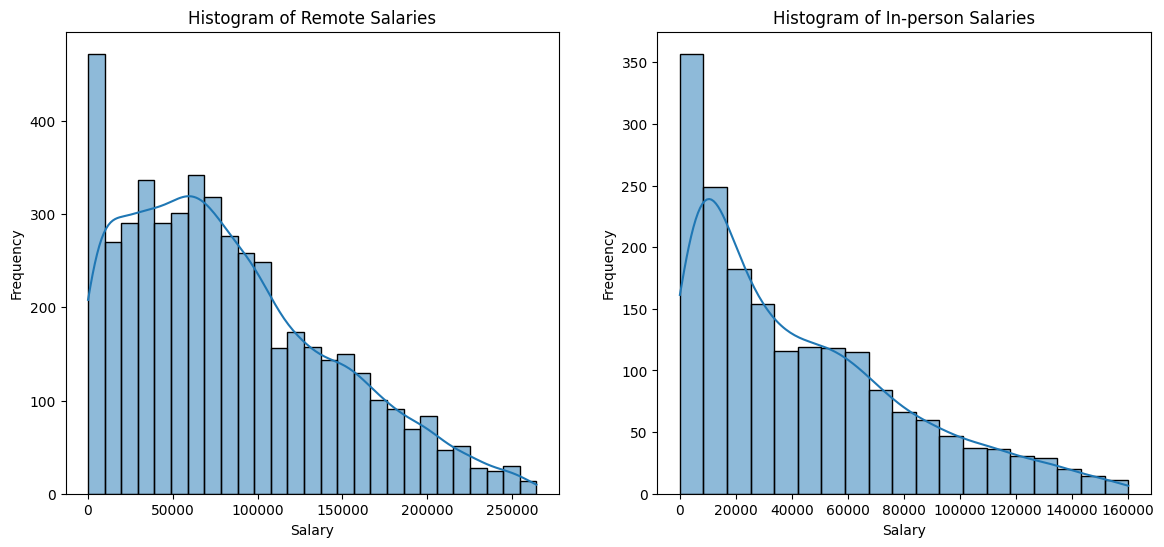

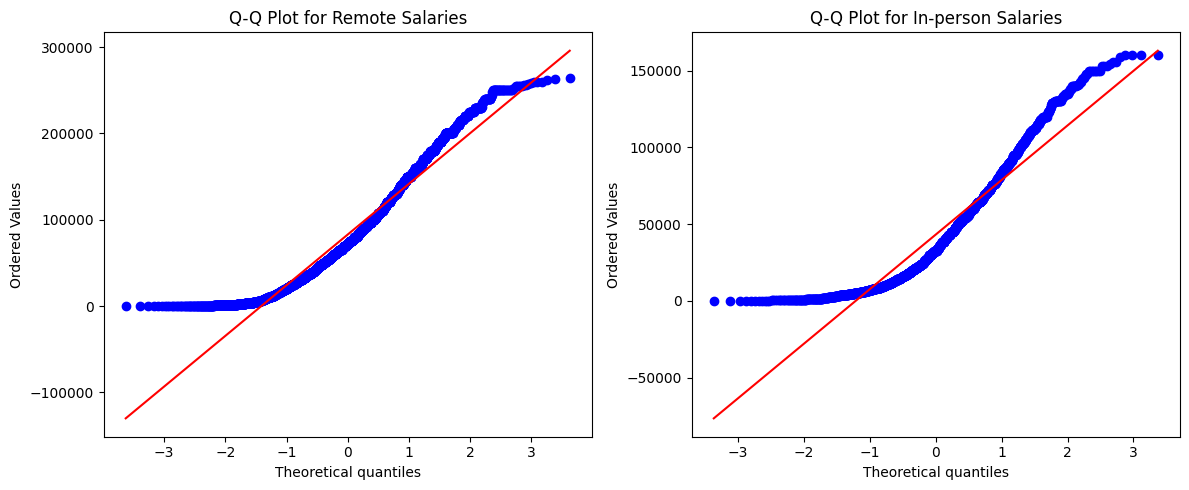

In [6]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(remote_salaries, kde=True)
plt.title('Histogram of Remote Salaries')
plt.xlabel('Salary')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(in_person_salaries, kde=True)
plt.title('Histogram of In-person Salaries')
plt.xlabel('Salary')
plt.ylabel('Frequency')

plt.show()

# Q-Q Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(remote_salaries, dist="norm", plot=plt)
plt.title('Q-Q Plot for Remote Salaries')

plt.subplot(1, 2, 2)
stats.probplot(in_person_salaries, dist="norm", plot=plt)
plt.title('Q-Q Plot for In-person Salaries')

plt.tight_layout()
plt.show()


In [7]:
from scipy.stats import shapiro

# Shapiro-Wilk Test for Remote Salaries
shapiro_remote_stat, shapiro_remote_p = shapiro(remote_salaries)
print(f"Shapiro-Wilk Test for Remote Salaries: Statistic={shapiro_remote_stat}, p-value={shapiro_remote_p}")

# Shapiro-Wilk Test for In-person Salaries
shapiro_in_person_stat, shapiro_in_person_p = shapiro(in_person_salaries)
print(f"Shapiro-Wilk Test for In-person Salaries: Statistic={shapiro_in_person_stat}, p-value={shapiro_in_person_p}")


Shapiro-Wilk Test for Remote Salaries: Statistic=0.9453917417113694, p-value=4.190207885606065e-39
Shapiro-Wilk Test for In-person Salaries: Statistic=0.899655592618932, p-value=3.8926181220233415e-33


In [8]:
from scipy.stats import levene

# Levene's Test
levene_stat, levene_p = levene(remote_salaries, in_person_salaries)
print(f"Levene's Test: Statistic={levene_stat}, p-value={levene_p}")


Levene's Test: Statistic=391.86751850465316, p-value=8.334115672795999e-85


Question 2c

Number of Remote workers: 4852
Number of In-person workers: 1845
95% Confidence Interval for Difference: [37256.422383145444, 42087.3745598859]


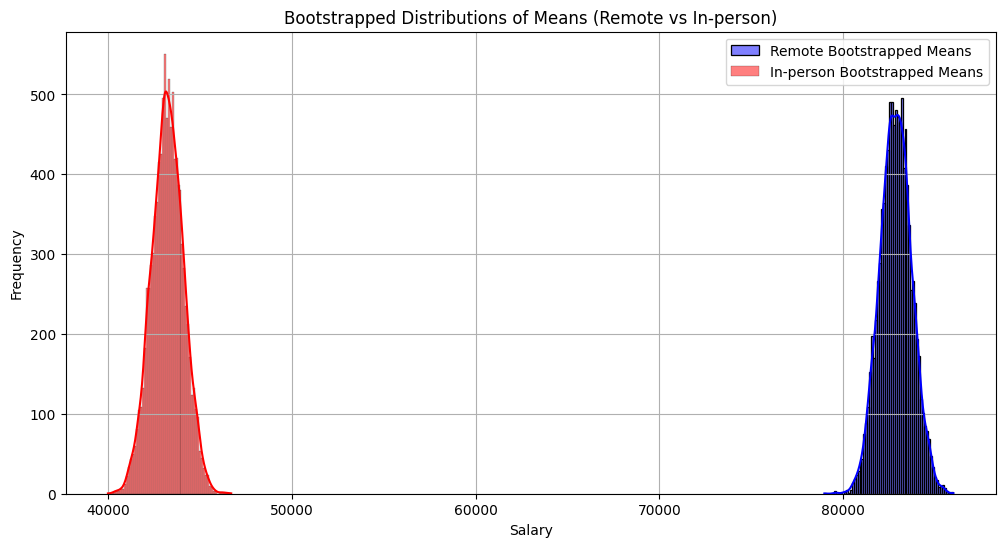

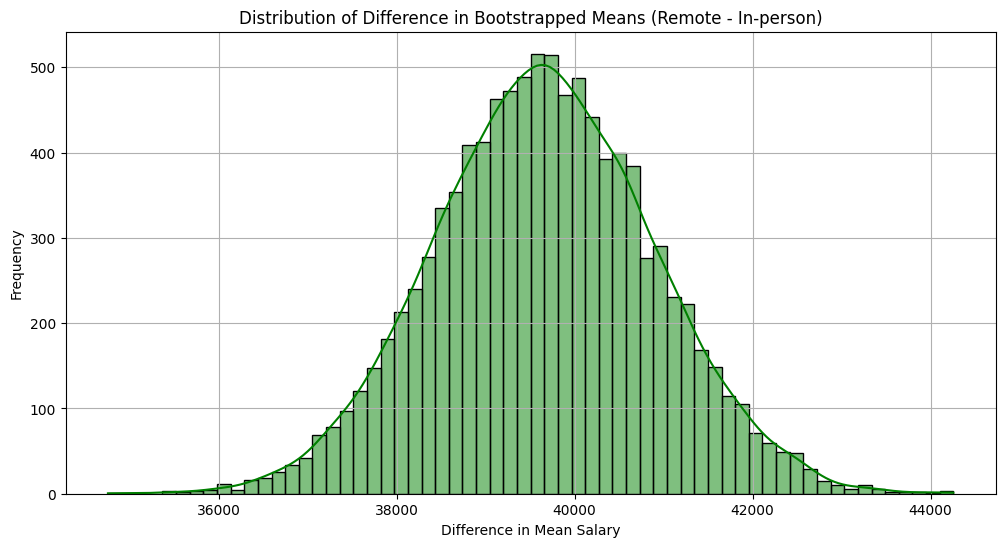

Mean of standardized differences (should equal t-value): 32.212679614632606
Manual t-statistic: 32.30051734614891


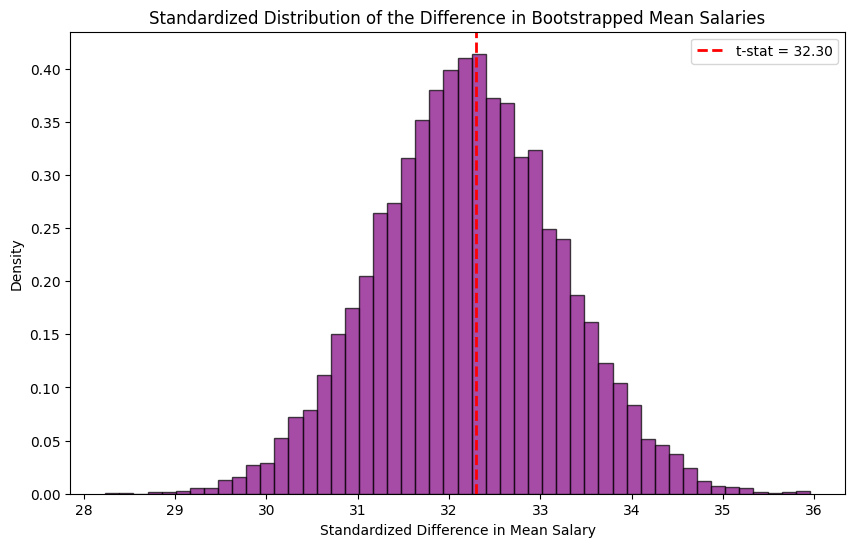

Bootstrapped Mean Salary (Remote): 82874.26093967436
Bootstrapped Mean Salary (In-person): 43220.78807246612
Mean Difference: 39653.47286720823
Standard Deviation of Difference: 1230.9895774456359


In [9]:
# Extract salary data for Remote jobs
salaries_remote = df_filtered_no_outliers[df_filtered_no_outliers['RemoteWork'] == 'Remote']['ConvertedCompYearly'].values

# Extract salary data for In-person jobs
salaries_in_person = df_filtered_no_outliers[df_filtered_no_outliers['RemoteWork'] == 'In-person']['ConvertedCompYearly'].values

# Get the sample sizes
n_remote = len(salaries_remote)
n_in_person = len(salaries_in_person)

print(f"Number of Remote workers: {n_remote}")
print(f"Number of In-person workers: {n_in_person}")

# Set the number of bootstrap replications
num_bootstrap_samples = 10000

# Arrays to store bootstrap results
boot_means_remote = np.empty(num_bootstrap_samples)
boot_means_in_person = np.empty(num_bootstrap_samples)
boot_mean_diffs = np.empty(num_bootstrap_samples)

# Perform bootstrapping
for i in range(num_bootstrap_samples):
    # Bootstrap sample for Remote workers
    boot_sample_remote = np.random.choice(salaries_remote, size=n_remote, replace=True)
    boot_means_remote[i] = boot_sample_remote.mean()

    # Bootstrap sample for In-person workers
    boot_sample_in_person = np.random.choice(salaries_in_person, size=n_in_person, replace=True)
    boot_means_in_person[i] = boot_sample_in_person.mean()

    # Compute the difference in means
    boot_mean_diffs[i] = boot_means_remote[i] - boot_means_in_person[i]


# 95% Confidence Interval for the difference
ci_lower = np.percentile(boot_mean_diffs, 2.5)
ci_upper = np.percentile(boot_mean_diffs, 97.5)
print(f"95% Confidence Interval for Difference: [{ci_lower}, {ci_upper}]")


# Plot 1: Distribution of bootstrapped means for Remote and In-person
plt.figure(figsize=(12, 6))
sns.histplot(boot_means_remote, color='blue', label='Remote Bootstrapped Means', kde=True)
sns.histplot(boot_means_in_person, color='red', label='In-person Bootstrapped Means', kde=True)
plt.title('Bootstrapped Distributions of Means (Remote vs In-person)')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Distribution of the difference in means
plt.figure(figsize=(12, 6))
sns.histplot(boot_mean_diffs, color='green', kde=True)
plt.title('Distribution of Difference in Bootstrapped Means (Remote - In-person)')
plt.xlabel('Difference in Mean Salary')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Standardize without subtracting the mean
std_diff = boot_mean_diffs.std()
standardized_diffs = boot_mean_diffs / std_diff

# Calculate the mean of the standardized differences
mean_standardized_diff = standardized_diffs.mean()

print(f"Mean of standardized differences (should equal t-value): {mean_standardized_diff}")

# Compare with the t-statistic from the manual calculation
print(f"Manual t-statistic: {t_statistic}")

# Plot 3: Standardized Distribution of the Difference in Bootstrapped Mean Salaries
plt.figure(figsize=(10, 6))
plt.hist(standardized_diffs, bins=50, color='purple', alpha=0.7, edgecolor='black', density=True)
plt.axvline(t_statistic, color='red', linestyle='dashed', linewidth=2, label=f't-stat = {t_statistic:.2f}')
plt.title('Standardized Distribution of the Difference in Bootstrapped Mean Salaries')
plt.xlabel('Standardized Difference in Mean Salary')
plt.ylabel('Density')
plt.legend()
plt.show()




Question 2d

In [10]:
import numpy as np
from scipy import stats

# Perform Welch's t-test on the bootstrapped data
t_stat_boot, p_value_boot = stats.ttest_ind(boot_means_remote, boot_means_in_person, equal_var=False)

# Print results
print("Bootstrapped Welch's t-test results:")
print(f"t-statistic: {t_stat_boot:.4f}")
print(f"p-value: {p_value_boot:.4f}")

# Compare with results from Question 2b
print("\nComparison with Question 2b results:")
print(f"Question 2b t-statistic: {t_stat:.4f}")
print(f"Question 2b p-value: {p_value:.4f}")

# Determine significance
alpha = 0.05
print(f"\nSignificance (α = {alpha}):")
print(f"Bootstrapped: {'Significant' if p_value_boot < alpha else 'Not significant'}")
print(f"Question 2b: {'Significant' if p_value < alpha else 'Not significant'}")


Bootstrapped Welch's t-test results:
t-statistic: 3235.6036
p-value: 0.0000

Comparison with Question 2b results:
Question 2b t-statistic: 32.3005
Question 2b p-value: 0.0000

Significance (α = 0.05):
Bootstrapped: Significant
Question 2b: Significant


Question 3a

In [12]:
import pandas as pd

# Load the dataset
file_path = 'clean_kaggle_data_2024.csv'
df = pd.read_csv(file_path)

# Filter the dataset to include only the specified education levels
df_filtered = df[df['EdLevel'].isin(["Bachelor’s degree", "Master’s degree", "Professional degree"])]

# Remove missing data in 'EdLevel' and 'ConvertedCompYearly'
df_filtered = df_filtered.dropna(subset=['EdLevel', 'ConvertedCompYearly'])

# Remove outliers within each group using the IQR method
def remove_outliers(df):
    Q1 = df['ConvertedCompYearly'].quantile(0.25)
    Q3 = df['ConvertedCompYearly'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['ConvertedCompYearly'] >= lower_bound) & (df['ConvertedCompYearly'] <= upper_bound)]

# Apply the function to each group
df_filtered_no_outliers = df_filtered.groupby('EdLevel').apply(remove_outliers).reset_index(drop=True)

# Compute descriptive statistics for each group
descriptive_stats = df_filtered_no_outliers.groupby('EdLevel')['ConvertedCompYearly'].describe()
print("Descriptive Statistics by Education Level:")
print(descriptive_stats)


Descriptive Statistics by Education Level:
                      count          mean           std    min      25%  \
EdLevel                                                                   
Bachelor’s degree    5427.0  71958.281924  56435.211857  115.0  24243.0   
Master’s degree      3326.0  69625.830427  43855.209844  104.0  37861.0   
Professional degree   456.0  87121.328947  54015.721468  132.0  48789.5   

                         50%       75%       max  
EdLevel                                           
Bachelor’s degree    60147.0  108000.0  245000.0  
Master’s degree      64444.0   95592.0  197627.0  
Professional degree  76345.5  112777.0  244585.0  


<ipython-input-12-4ec979b44e13>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered_no_outliers = df_filtered.groupby('EdLevel').apply(remove_outliers).reset_index(drop=True)


In [13]:
!pip install pingouin


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.8 MB/s eta 0:00:00


Question 3b


Shapiro-Wilk Test for Normality:
Bachelor's degree: Statistic=0.9292300526165168, p-value=6.036394967503045e-45
Master's degree: Statistic=0.9669939623216295, p-value=5.679046148718369e-27
Professional degree: Statistic=0.9476171107050633, p-value=1.2813381188557117e-11
Levene's Test: Statistic=110.59448867600966, p-value=3.4462826272177964e-48


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5427.
  res = hypotest_fun_out(*samples, **kwds)


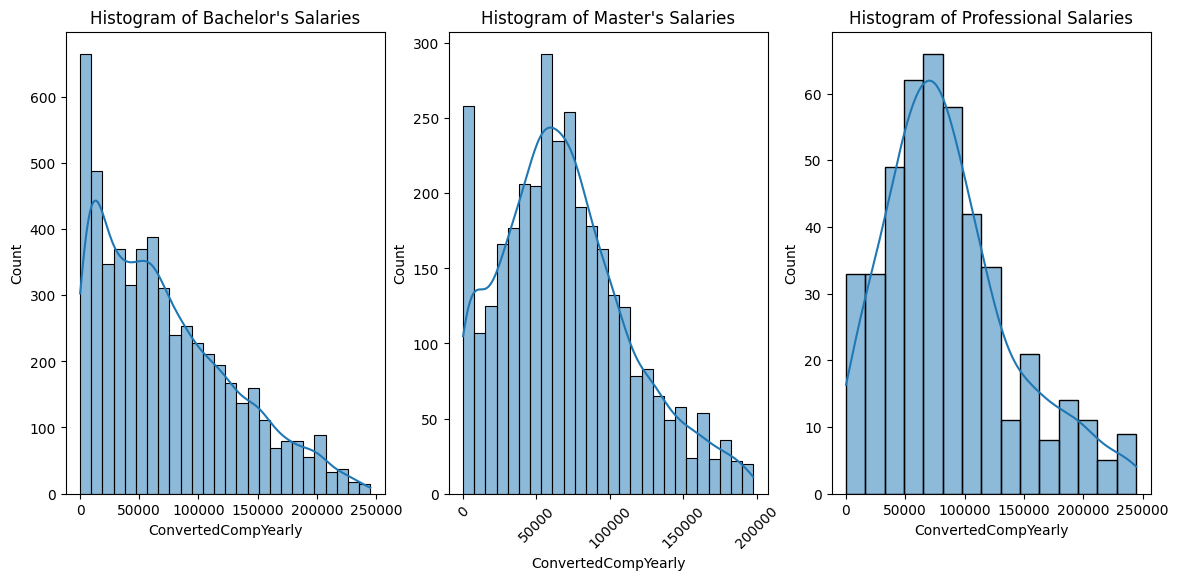

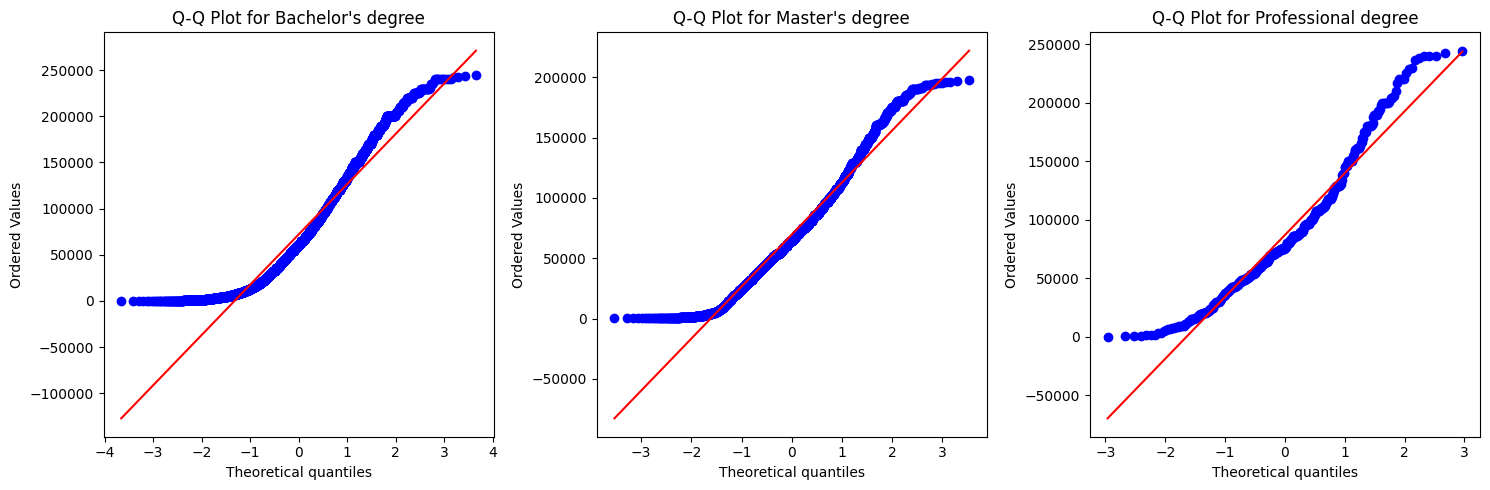


Welch's ANOVA Result:
    Source  ddof1        ddof2          F         p-unc      np2
0  EdLevel      2  1244.817104  22.273228  3.132694e-10  0.00489


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import levene
import pingouin as pg

# Extract salary data for each education level
salaries_bachelors = df_filtered_no_outliers[df_filtered_no_outliers['EdLevel'] == "Bachelor’s degree"]['ConvertedCompYearly']
salaries_masters = df_filtered_no_outliers[df_filtered_no_outliers['EdLevel'] == "Master’s degree"]['ConvertedCompYearly']
salaries_professional = df_filtered_no_outliers[df_filtered_no_outliers['EdLevel'] == "Professional degree"]['ConvertedCompYearly']


# Shapiro-Wilk Test
print("\nShapiro-Wilk Test for Normality:")
shapiro_bachelors_stat, shapiro_bachelors_p = shapiro(salaries_bachelors)
print(f"Bachelor's degree: Statistic={shapiro_bachelors_stat}, p-value={shapiro_bachelors_p}")
shapiro_masters_stat, shapiro_masters_p = shapiro(salaries_masters)
print(f"Master's degree: Statistic={shapiro_masters_stat}, p-value={shapiro_masters_p}")
shapiro_professional_stat, shapiro_professional_p = shapiro(salaries_professional)
print(f"Professional degree: Statistic={shapiro_professional_stat}, p-value={shapiro_professional_p}")


# Levene's Test
levene_stat, levene_p = levene(salaries_bachelors, salaries_masters,salaries_professional)
print(f"Levene's Test: Statistic={levene_stat}, p-value={levene_p}")

# Histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.histplot(salaries_bachelors, kde=True)
plt.title("Histogram of Bachelor's Salaries")

plt.subplot(1, 3, 2)
sns.histplot(salaries_masters, kde=True)
plt.title("Histogram of Master's Salaries")
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees to prevent overlap


plt.subplot(1, 3, 3)
sns.histplot(salaries_professional, kde=True)
plt.title("Histogram of Professional Salaries")

plt.show()

# Q-Q Plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
stats.probplot(salaries_bachelors, dist="norm", plot=plt)
plt.title("Q-Q Plot for Bachelor's degree")

plt.subplot(1, 3, 2)
stats.probplot(salaries_masters, dist="norm", plot=plt)
plt.title("Q-Q Plot for Master's degree")

plt.subplot(1, 3, 3)
stats.probplot(salaries_professional, dist="norm", plot=plt)
plt.title("Q-Q Plot for Professional degree")

plt.tight_layout()
plt.show()

# Perform Welch's ANOVA using pingouin
welch_anova_result = pg.welch_anova(dv='ConvertedCompYearly', between='EdLevel', data=df_filtered_no_outliers)

print("\nWelch's ANOVA Result:")
print(welch_anova_result)



Question 3c

Number of Bachelor's degree holders: 5427
Number of Master's degree holders: 3326
Number of Professional degree holders: 456
95% Confidence Interval for Difference (Bachelor's - Master's): [182.98455872683047, 4485.7495147118]
95% Confidence Interval for Difference (Bachelor's - Professional): [10082.9339215836, 20270.33161634565]
95% Confidence Interval for Difference (Master's - Professional): [12373.952875174065, 22653.672073232163]


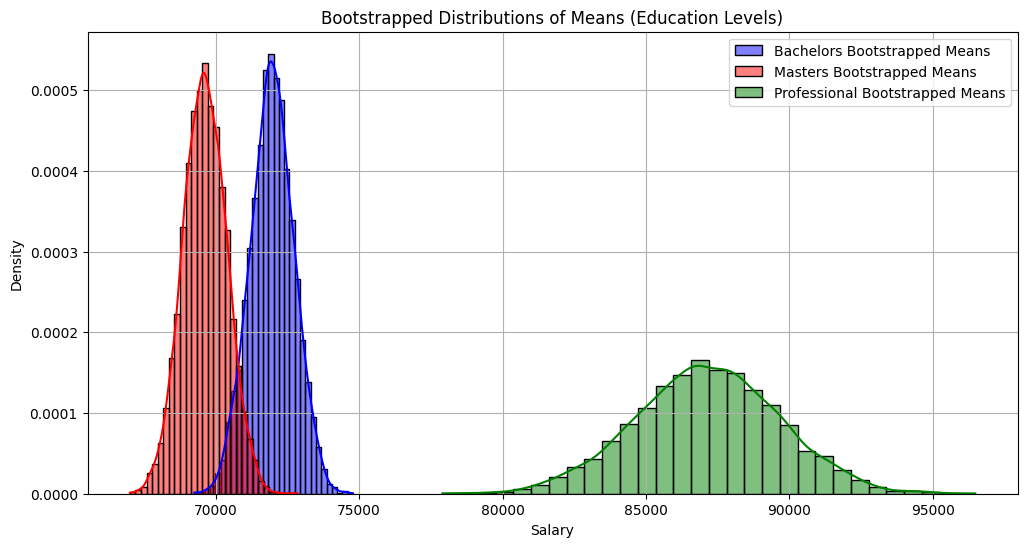

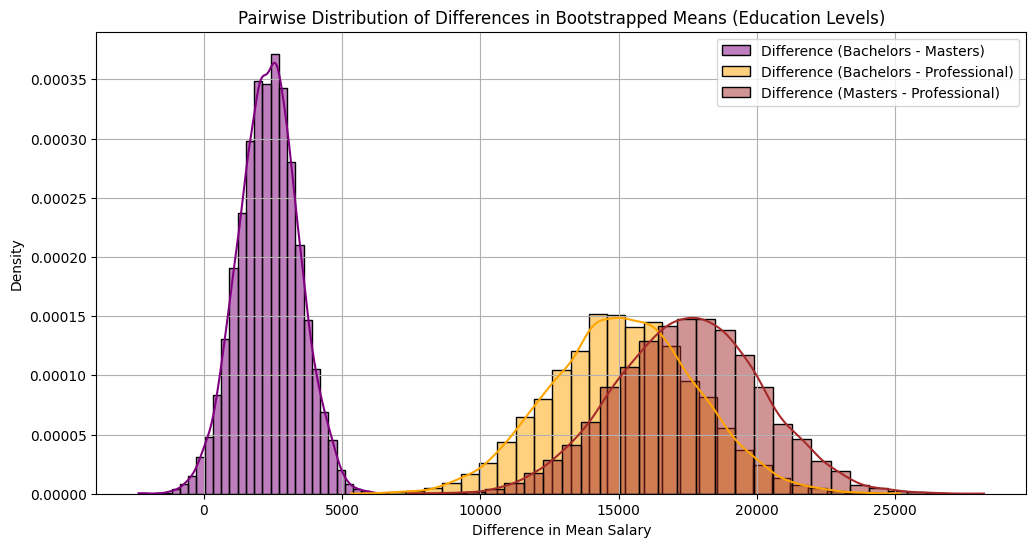

t-statistics for Pairwise Comparisons:
Bachelor's vs Master's: t = 2.1459114966096338
Bachelor's vs Professional: t = 5.793916158760628
Master's vs Professional: t = 6.676836548381607

Means of Standardized Differences (should equal t-statistics):
Bachelor's vs Master's: mean = 2.1562960147277894
Bachelor's vs Professional: mean = 5.796175306947286
Master's vs Professional: mean = 6.683400445020532


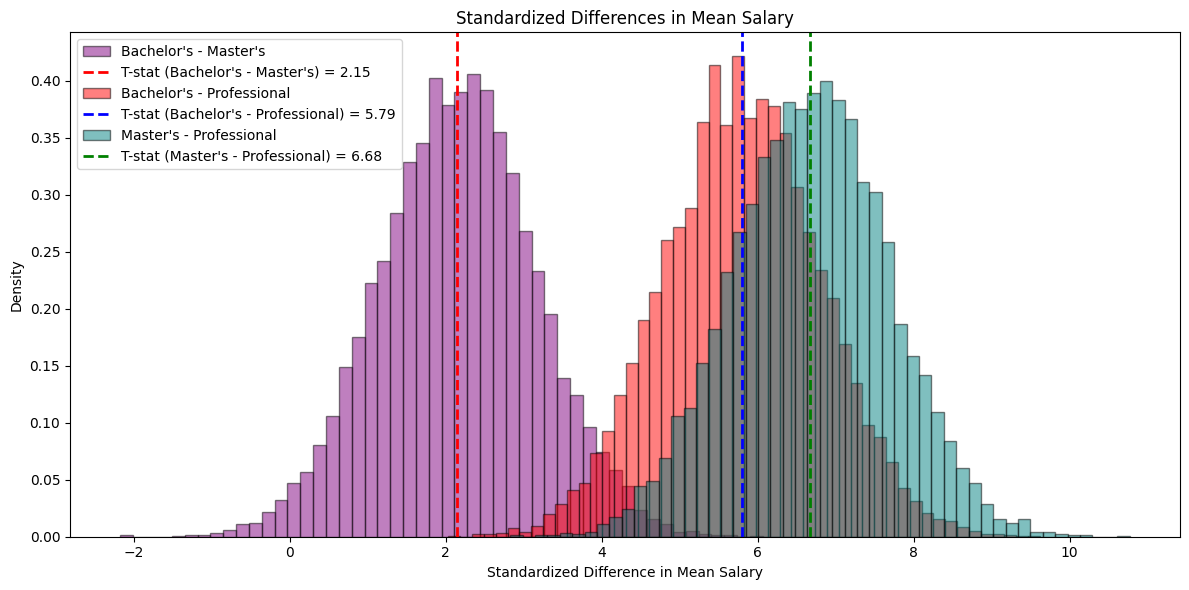

Bootstrapped Mean Salary (Bachelor's): 71964.71415065414
Bootstrapped Mean Salary (Master's): 69620.97542937462
Bootstrapped Mean Salary (Professional): 87133.67350877191
Mean Difference (Bachelor's - Master's): 2343.7387212795124
Mean Difference (Bachelor's - Professional): 15168.959358117794
Mean Difference (Master's - Professional): 17512.6980793973


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


# Extract salary data for each education level
salaries_bachelors = df_filtered_no_outliers[df_filtered_no_outliers['EdLevel'] == "Bachelor’s degree"]['ConvertedCompYearly'].values
salaries_masters = df_filtered_no_outliers[df_filtered_no_outliers['EdLevel'] == "Master’s degree"]['ConvertedCompYearly'].values
salaries_professional = df_filtered_no_outliers[df_filtered_no_outliers['EdLevel'] == "Professional degree"]['ConvertedCompYearly'].values

# Get the sample sizes
n_bachelors = len(salaries_bachelors)
n_masters = len(salaries_masters)
n_professional = len(salaries_professional)

print(f"Number of Bachelor's degree holders: {n_bachelors}")
print(f"Number of Master's degree holders: {n_masters}")
print(f"Number of Professional degree holders: {n_professional}")

# Set the number of bootstrap replications
num_bootstrap_samples = 10000

# Arrays to store bootstrap results
boot_means_bachelors = np.empty(num_bootstrap_samples)
boot_means_masters = np.empty(num_bootstrap_samples)
boot_means_professional = np.empty(num_bootstrap_samples)
boot_mean_diffs_bachelors_masters = np.empty(num_bootstrap_samples)
boot_mean_diffs_bachelors_professional = np.empty(num_bootstrap_samples)
boot_mean_diffs_masters_professional = np.empty(num_bootstrap_samples)

# Perform bootstrapping
for i in range(num_bootstrap_samples):
    # Bootstrap sample for Bachelor's degree holders
    boot_sample_bachelors = np.random.choice(salaries_bachelors, size=n_bachelors, replace=True)
    boot_means_bachelors[i] = boot_sample_bachelors.mean()

    # Bootstrap sample for Master's degree holders
    boot_sample_masters = np.random.choice(salaries_masters, size=n_masters, replace=True)
    boot_means_masters[i] = boot_sample_masters.mean()

    # Bootstrap sample for Professional degree holders
    boot_sample_professional = np.random.choice(salaries_professional, size=n_professional, replace=True)
    boot_means_professional[i] = boot_sample_professional.mean()

    # Compute the differences in means
    boot_mean_diffs_bachelors_masters[i] = boot_means_bachelors[i] - boot_means_masters[i]
    boot_mean_diffs_bachelors_professional[i] = boot_means_professional[i] - boot_means_bachelors[i]
    boot_mean_diffs_masters_professional[i] = boot_means_professional[i] - boot_means_masters[i]

# 95% Confidence Intervals for the differences
ci_bachelors_masters = [np.percentile(boot_mean_diffs_bachelors_masters, 2.5), np.percentile(boot_mean_diffs_bachelors_masters, 97.5)]
ci_bachelors_professional = [np.percentile(boot_mean_diffs_bachelors_professional, 2.5), np.percentile(boot_mean_diffs_bachelors_professional, 97.5)]
ci_masters_professional = [np.percentile(boot_mean_diffs_masters_professional, 2.5), np.percentile(boot_mean_diffs_masters_professional, 97.5)]

print(f"95% Confidence Interval for Difference (Bachelor's - Master's): {ci_bachelors_masters}")
print(f"95% Confidence Interval for Difference (Bachelor's - Professional): {ci_bachelors_professional}")
print(f"95% Confidence Interval for Difference (Master's - Professional): {ci_masters_professional}")

# Plot 1: Bootstrapped distributions of means for each education level
plt.figure(figsize=(12, 6))
sns.histplot(boot_means_bachelors, color='blue', label='Bachelors Bootstrapped Means', kde=True, stat="density", bins=30)
sns.histplot(boot_means_masters, color='red', label='Masters Bootstrapped Means', kde=True, stat="density", bins=30)
sns.histplot(boot_means_professional, color='green', label='Professional Bootstrapped Means', kde=True, stat="density", bins=30)
plt.title('Bootstrapped Distributions of Means (Education Levels)')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Pairwise distribution of the differences in means
plt.figure(figsize=(12, 6))
sns.histplot(boot_mean_diffs_bachelors_masters, color='purple', label='Difference (Bachelors - Masters)', kde=True, stat="density", bins=30)
sns.histplot(boot_mean_diffs_bachelors_professional, color='orange', label='Difference (Bachelors - Professional)', kde=True, stat="density", bins=30)
sns.histplot(boot_mean_diffs_masters_professional, color='brown', label='Difference (Masters - Professional)', kde=True, stat="density", bins=30)
plt.title('Pairwise Distribution of Differences in Bootstrapped Means (Education Levels)')
plt.xlabel('Difference in Mean Salary')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Normalized distribution of differences in means

# Step 1: Calculate Observed Mean Differences and Standard Errors
observed_diff_bachelors_masters = salaries_bachelors.mean() - salaries_masters.mean()
observed_diff_bachelors_professional = salaries_professional.mean() - salaries_bachelors.mean()
observed_diff_masters_professional = salaries_professional.mean() - salaries_masters.mean()

std_diff_bachelors_masters = boot_mean_diffs_bachelors_masters.std()
std_diff_bachelors_professional = boot_mean_diffs_bachelors_professional.std()
std_diff_masters_professional = boot_mean_diffs_masters_professional.std()

# Step 2: Calculate the t-statistics
t_stat_bachelors_masters = observed_diff_bachelors_masters / std_diff_bachelors_masters
t_stat_bachelors_professional = observed_diff_bachelors_professional / std_diff_bachelors_professional
t_stat_masters_professional = observed_diff_masters_professional / std_diff_masters_professional

print("t-statistics for Pairwise Comparisons:")
print(f"Bachelor's vs Master's: t = {t_stat_bachelors_masters}")
print(f"Bachelor's vs Professional: t = {t_stat_bachelors_professional}")
print(f"Master's vs Professional: t = {t_stat_masters_professional}")

# Step 3: Standardize the Differences Without Subtracting the Mean
standardized_diffs_bachelors_masters = boot_mean_diffs_bachelors_masters / std_diff_bachelors_masters
standardized_diffs_bachelors_professional = boot_mean_diffs_bachelors_professional / std_diff_bachelors_professional
standardized_diffs_masters_professional = boot_mean_diffs_masters_professional / std_diff_masters_professional

mean_standardized_bachelors_masters = standardized_diffs_bachelors_masters.mean()
mean_standardized_bachelors_professional = standardized_diffs_bachelors_professional.mean()
mean_standardized_masters_professional = standardized_diffs_masters_professional.mean()

print("\nMeans of Standardized Differences (should equal t-statistics):")
print(f"Bachelor's vs Master's: mean = {mean_standardized_bachelors_masters}")
print(f"Bachelor's vs Professional: mean = {mean_standardized_bachelors_professional}")
print(f"Master's vs Professional: mean = {mean_standardized_masters_professional}")

plt.figure(figsize=(12, 6))

# Plot histogram for Bachelor's vs Master's
plt.hist(standardized_diffs_bachelors_masters, bins=50, color='purple', alpha=0.5, edgecolor='black', density=True, label="Bachelor's - Master's")
plt.axvline(t_stat_bachelors_masters, color='red', linestyle='dashed', linewidth=2, label=f"T-stat (Bachelor\'s - Master's) = {t_stat_bachelors_masters:.2f}")

# Plot histogram for Bachelor's vs Professional
plt.hist(standardized_diffs_bachelors_professional, bins=50, color='red', alpha=0.5, edgecolor='black', density=True, label="Bachelor's - Professional")
plt.axvline(t_stat_bachelors_professional, color='blue', linestyle='dashed', linewidth=2, label=f"T-stat (Bachelor's - Professional) = {t_stat_bachelors_professional:.2f}")

# Plot histogram for Master's vs Professional
plt.hist(standardized_diffs_masters_professional, bins=50, color='teal', alpha=0.5, edgecolor='black', density=True, label="Master's - Professional")
plt.axvline(t_stat_masters_professional, color='green', linestyle='dashed', linewidth=2, label=f"T-stat (Master's - Professional) = {t_stat_masters_professional:.2f}")

# Customize plot
plt.title("Standardized Differences in Mean Salary")
plt.xlabel("Standardized Difference in Mean Salary")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


# Analyze Results
mean_bachelors = boot_means_bachelors.mean()
mean_masters = boot_means_masters.mean()
mean_professional = boot_means_professional.mean()
mean_diff_bachelors_masters = boot_mean_diffs_bachelors_masters.mean()
mean_diff_bachelors_professional = boot_mean_diffs_bachelors_professional.mean()
mean_diff_masters_professional = boot_mean_diffs_masters_professional.mean()

print(f"Bootstrapped Mean Salary (Bachelor's): {mean_bachelors}")
print(f"Bootstrapped Mean Salary (Master's): {mean_masters}")
print(f"Bootstrapped Mean Salary (Professional): {mean_professional}")
print(f"Mean Difference (Bachelor's - Master's): {mean_diff_bachelors_masters}")
print(f"Mean Difference (Bachelor's - Professional): {mean_diff_bachelors_professional}")
print(f"Mean Difference (Master's - Professional): {mean_diff_masters_professional}")


Question 3d

In [20]:
import pandas as pd

# Create a DataFrame for bootstrapped means
boot_means_df = pd.DataFrame({'BootstrappedMean': np.concatenate([boot_means_bachelors, boot_means_masters, boot_means_professional]),
    'EdLevel': (['Bachelor’s degree'] * num_bootstrap_samples + ['Master’s degree'] * num_bootstrap_samples + ['Professional degree'] * num_bootstrap_samples)})

import pingouin as pg

# Perform Welch's ANOVA
welch_anova_result = pg.welch_anova(dv='BootstrappedMean', between='EdLevel', data=boot_means_df)

print("\nWelch's ANOVA Result:")
print(welch_anova_result)




Welch's ANOVA Result:
    Source  ddof1        ddof2              F  p-unc       np2
0  EdLevel      2  18271.09747  226820.905476    0.0  0.960447
